<a href="https://colab.research.google.com/github/SiyuChen1/C-LearnSummary/blob/master/assignment10_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 10: X-Ray Pneumonia Detection

In this assignment, you are tasked with developing your own classifier for pneumonia in X-ray images. You will go through to the complete ML development cycle from loading and preprocessing your data to evaluating your models.

Download and extract the X-Ray dataset from Ilias to the same directory as your Jupyter notebook. The data is already split into a training, validation, and testing set. The dataset originates from the paper [Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning
](https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5).

You may use any packages, we encountered during the exercises (numpy, matplotlib, scikit-learn, scikit-image, pandas, pytorch) as well as the Python standard library.

You should (at least) address the following points in your development process:

- The dataset is imbalanced. Do at least one of the following:
    - Augment your dataset by including rotated, flipped, or brightened images. This will also improve the generalization capabilities of your model.
    - or: Modify your objective function by weighting the classes differently.
- Optimize the hyperparameters of your models using grid-search or random-search on the validation set.
- Consider at least two classes of models, e.g. CNN and SVM. At least one of your model classes should be some type of neural network implemented in PyTorch.
- After the hyperparameter optimization, select the best-performing models of each class. Evaluate these models on the testing data and visualize your results.


*Note*: You have 2 weeks to complete this assignment. The assignment is optional for B.Sc.Data Science students, who have an alternative easier assignment 10 on clustering. If you already have successfully submitted 7 assignments, you do not need to submit this assignment.
Presenting this assignment in a video counts as **2 video presentations**. Please indicate if you wish to present at the top of the notebook.

- Siyu Chen 3494095

**I am glad to present this project.**

## Step 1: download data set

Make directionary to store the total data set, download the data set and unpack the data set

1.  download and unpack data set

In [ ]:
!mkdir data
!gdown https://ipvs.informatik.uni-stuttgart.de/cloud/s/XjwFgNdaRjPHkTp/download
!mv download data
!cd data && mv download download.zip && unzip download.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0502-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0503-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0504-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0505-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0505-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0505-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0506-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0507-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0509-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0509-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0509-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0511-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0511-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0512-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0517-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0517-0001.jpeg  
  infla


2. check the data set


In [ ]:
!cd data && pwd && cd chest_xray && ls

/content/data
chest_xray  __MACOSX  test  train  val


## Step 2: Using Pytorch to creat CNN 

1. Import necessary libraries 

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from skimage import io, transform
from skimage.color import rgb2gray
from torchvision import transforms, utils
from PIL import Image
import torch.nn.functional as F

2. Check CUDA

In [ ]:
# The default device name is 'cpu'. 
# You can access your GPU with the name 'cuda' 
# or if you have multiple GPUs indexed like 'cuda:0', 'cuda:1', ...
device_name = 'cuda'
device = torch.device(device_name)
device

device(type='cuda')

3. Build X-Ray data set as a subclass of `data.Dataset `

In [ ]:
class XRayDataset(data.Dataset):
    """X-Ray dataset."""

    def __init__(self, dir_path, transform=None):
        def load_data(directory):
            directories = [d for d in os.listdir(directory)
                        if os.path.isdir(os.path.join(directory, d))]
            labels = []
            file_names_all = []
            for d in directories:
                label_directory = os.path.join(directory, d)
                for f in os.listdir(label_directory):
                    if f.endswith(".jpeg"):
                        file_names_all.append(os.path.join(label_directory, f))
                    if 'NORMAL' == d:
                        labels.append(0)
                    else:
                        labels.append(1)
            return file_names_all, labels
        self.file_names, self.labels = load_data(dir_path)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.file_names[idx]
        # image = io.imread(img_name)
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        return {'x': image, 'y': self.labels[idx]}

4. Transform functions 

In [ ]:
class Resize(object):
    """
        Convert a RGB image to a grey image.
    """

    def __init__(self,output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, image):
        # print('input',image.shape)

        if isinstance(self.output_size, int) :
            self.output_size = (self.output_size, self.output_size) 
        
        # print('outputsize',self.output_size)
        img = transform.resize(image, self.output_size)
        # print('real',img.shape)
        return img

In [ ]:
class ToGrey(object):
    """
        Convert a RGB image to a grey image.
    """

    def __init__(self):
        pass

    def __call__(self, image):

        if len(image.shape) == 3:
            print('enter')
            image = rgb2gray(image)
        # plt.imshow(image)
        return image

In [ ]:
from skimage import exposure

class Brightness(object):
    """
        change the brightness of the image
    """

    def __init__(self, gamma):
        self.gamma = gamma

    def __call__(self, image):
        img = exposure.adjust_gamma(image, self.gamma)
        return img

In [ ]:
class RotateImage(object):
    """
        Convert a RGB image to a grey image.
    """

    def __init__(self, angle):
        self.angle = angle

    def __call__(self, image):
        # print('before ratation',image.shape)
        img = transform.rotate(image, self.angle) 
        # print('after rotation',img.shape)
        # plt.imshow(img)
        return img

In [ ]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __init__(self):
        pass

    def __call__(self, image):
        # print('numpy',image.shape)
        img = np.expand_dims(image, axis=0)
        # print('torch',image.shape)
        return torch.from_numpy(image)

In [ ]:
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, image):

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        return image


5. Visualise the data augmentation 

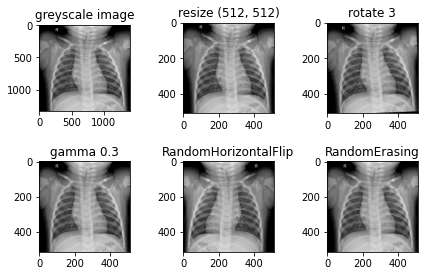

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3)

ax = axes.ravel()

resize_image_size = (512,512)
angle = 3
gamma = 0.3
# composed_1 = transforms.Compose([ToGrey()])
# composed_2 = transforms.Compose([ToGrey(), Resize(resize_image_size)])
# composed_3 = transforms.Compose([ToGrey(), Resize(resize_image_size),RotateImage(angle)])
# composed_4 = transforms.Compose([ToGrey(), Resize(resize_image_size),Brightness(gamma)])
composed_1 = transforms.Compose([transforms.Grayscale()])
composed_2 = transforms.Compose([transforms.Grayscale(), transforms.Resize(resize_image_size)])
composed_3 = transforms.Compose([transforms.Grayscale(), transforms.Resize(resize_image_size), transforms.RandomRotation(angle)])
composed_4 = transforms.Compose([transforms.Grayscale(), transforms.Resize(resize_image_size), transforms.ColorJitter(gamma)])
composed_5 = transforms.Compose([transforms.Grayscale(), transforms.Resize(resize_image_size), transforms.RandomHorizontalFlip()])
composed_6 = transforms.Compose([transforms.Grayscale(), transforms.Resize(resize_image_size), transforms.RandomErasing()])
composed_list = [composed_1,composed_2,composed_3,composed_4, composed_5, composed_5]
title_list = ['greyscale image','resize ' + str(resize_image_size),'rotate ' + str(angle),'gamma ' + str(gamma),'RandomHorizontalFlip','RandomErasing']

for i in range(6):
    xray_dataset = XRayDataset(dir_path='./data/chest_xray/train/',transform=composed_list[i])
    x_data = xray_dataset[0]['x']
    # print(np.array(x_data))
    # print(np.min(x_data), np.max(x_data))
    ax[i].imshow(x_data,cmap='gray')
    ax[i].set_title(title_list[i])

plt.tight_layout()
plt.show()


6. Create CNN using `nn.Module`

-  Two Modules: `class MyAlexNet(nn.Module):` and `class MyMiniAlexNet(nn.Module):`
- `class MyAlexNet(nn.Module):` has more parameters and is deeper than `class MyMiniAlexNet(nn.Module):`

In [ ]:
class MyMiniAlexNet(nn.Module):
    def __init__(self, output_dimension):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, (11,11),stride=2)
        self.pool1 = nn.MaxPool2d((3,3), stride=2)
        self.conv2 = nn.Conv2d(16, 32, (5,5), stride=4)
        self.pool2 = nn.MaxPool2d((3,3), stride=2)
        self.conv3 = nn.Conv2d(32, 4, (3,3), stride=2)
        self.fc1 = nn.Linear(4*7*7, 2*7)
        self.dropout = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(2*7, output_dimension)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, X, training=False, feature_extra=False):
        # print(X.shape)
        X = self.conv1(X)
        # print(X.shape)
        X = self.pool1(X)
        # print(X.shape)
        X = self.conv2(X)
        # print(X.shape)
        X = self.pool2(X)
        # print(X.shape)
        X = self.conv3(X)
        # print(X.shape)
        X = torch.flatten(X, start_dim=1)
        # print(X.shape)
        X = F.relu(self.fc1(X))
        if training:
            X = self.dropout(X)
        if feature_extra:
            return X
        X = self.softmax(self.fc2(X))
        return X

In [ ]:
class MyAlexNet(nn.Module):
    def __init__(self, output_dimension):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, (11,11),stride=2)
        self.pool1 = nn.MaxPool2d((3,3), stride=2)
        self.conv2 = nn.Conv2d(8, 16, (5,5), padding=2)
        self.pool2 = nn.MaxPool2d((3,3), stride=2)
        self.conv3 = nn.Conv2d(16, 32, (3,3), padding=1)
        self.conv4 = nn.Conv2d(32, 8, (3,3), padding=1)
        self.pool3 = nn.MaxPool2d((3,3), stride=2)
        self.conv5 = nn.Conv2d(8, 2, (3,3), padding=1)
        self.fc1 = nn.Linear(1800, 256)
        self.dropout = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(256, 32)
        self.fc3 = nn.Linear(32, output_dimension)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, X, training=False, feature_extra=False):
        # print(X.shape)
        X = self.conv1(X)
        # print(X.shape)
        X = self.pool1(X)
        # print(X.shape)
        X = self.conv2(X)
        # print(X.shape)
        X = self.pool2(X)
        # print(X.shape)
        X = self.conv3(X)
        # print(X.shape)
        X = self.conv4(X)
        # print(X.shape)
        X = self.pool3(X)
        # print(X.shape)
        X = self.conv5(X)
        # print(X.shape)
        X = torch.flatten(X, start_dim=1)
        # print(X.shape)
        X = F.relu(self.fc1(X))
        if training:
            X = self.dropout(X)
        X = F.relu(self.fc2(X))
        if feature_extra:
            return X
        X = self.softmax(self.fc3(X))
        # print(X.shape)
        return X

7. Compute class weight for training

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
def load_train_dataset_y():
    import os 
    def load_data(directory):
        directories = [d for d in os.listdir(directory)
                       if os.path.isdir(os.path.join(directory, d))]
        labels = []
        for d in directories:
            label_directory = os.path.join(directory, d)
            file_names = [os.path.join(label_directory, f)
                          for f in os.listdir(label_directory)
                          if f.endswith(".jpeg")]
            for f in file_names:
                if d == "NORMAL":
                    labels.append(0)
                else:
                    labels.append(1)
        labels = np.array(labels)
        return labels
            
    y_train = load_data('./data/chest_xray/train/')
    return y_train

y_train = load_train_dataset_y()
print(np.bincount(y_train))
class_weights = compute_class_weight(class_weight='balanced',classes=np.unique(y_train), y=y_train)
print(class_weights)

# mean_list = []

# composed_compute = transforms.Compose([transforms.Grayscale(), transforms.Resize(resize_image_size)])

# data_train_compute = XRayDataset(dir_path='./data/chest_xray/train/',transform=composed_compute)

# for id in range(len(data_train_compute)):
#     mean_list.append(np.mean(xray_dataset[i]['x']))

# print(mean_list)

[1341 3875]
[1.9448173  0.67303226]


8. Configure Google Colab to store the trained parameters

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
!ls /content/gdrive/My\ Drive

 001948974414.doc_02_01_20_10_29_07.pdf   Europass
 Aufenthaltstitel			  foo.txt
 classifier_20.pth			 'Machine Learning'
 classifier_epoches_25_big_lr.pth	  MyCode
 classifier_epoches_25.pth		  sim_classifier.pth
 classifier.pth				 'Uni Stuttgart'
'Colab Notebooks'			 'Wohnen mit Hilfe'


9. Train CNN

In [ ]:
resize_image_size = (512,512)
angle = 2
gamma = 0.5

In [ ]:
myalexnet = MyAlexNet(2).to(device)

composed_train = transforms.Compose([transforms.Grayscale(), transforms.Resize(resize_image_size), transforms.RandomRotation(angle), 
                               transforms.ColorJitter(gamma),transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.RandomErasing()])

composed_val = transforms.Compose([transforms.Grayscale(), transforms.Resize(resize_image_size)])

data_train = XRayDataset(dir_path='./data/chest_xray/train/',transform=composed_train)
data_val = XRayDataset(dir_path='./data/chest_xray/val/',transform=composed_val)

epochs = 20
report_every_epoch = 1
batch_size = 512
learning_rate = 1e-3

losses = []

weights = torch.FloatTensor(class_weights).cuda()
criterion = nn.CrossEntropyLoss(weight=weights)

optimizer = optim.Adam(myalexnet.parameters(), lr=learning_rate)

for epoch in range(epochs):
    data_loader = data.DataLoader(data_train, batch_size=batch_size, shuffle=True)
    epoch_loss = 0.0
    
    for batch in data_loader:
        myalexnet.zero_grad()
        
        # Change! #
        yhat = myalexnet.forward(batch['x'].to(device),training=True)
        batch_loss = criterion(yhat, batch['y'].to(device))
        
        epoch_loss += batch_loss.item()
        batch_loss.backward()
        optimizer.step()
    losses.append(epoch_loss)
    
    with torch.no_grad():
        # for sample in data_val:
        #     print(np.array(sample['y']))
        x = np.array([np.expand_dims(np.array(sample['x']),axis=0) for sample in data_val])
        # print(x.shape)
        y = np.array([sample['y'] for sample in data_val])
        # Change! #
        x = torch.from_numpy(x).float().to(device)
        y = torch.from_numpy(y).to(device)
        
        yhat = myalexnet.forward(x)
        error_val = criterion(yhat, y).item()
        
    if ((epoch + 1) % report_every_epoch) == 0 or epoch == 0:
        print(f'Epoch {epoch+1}/{epochs}\n- Loss: {epoch_loss:.03f} - Vali: {error_val:.03f}')

# model_save_name = 'sim_classifier.pth'
model_save_name = 'classifier_epoches_20.pth'
path = F"/content/gdrive/My Drive/{model_save_name}" 
# To save just take your trained module and call the torch.save function.
torch.save(myalexnet.state_dict(), path)

Epoch 1/20
- Loss: 7.480 - Vali: 0.878
Epoch 2/20
- Loss: 7.067 - Vali: 0.778
Epoch 3/20
- Loss: 5.912 - Vali: 0.535
Epoch 4/20
- Loss: 6.000 - Vali: 0.778
Epoch 5/20
- Loss: 5.348 - Vali: 0.470
Epoch 6/20
- Loss: 5.014 - Vali: 0.470
Epoch 7/20
- Loss: 4.942 - Vali: 0.531
Epoch 8/20
- Loss: 4.873 - Vali: 0.378
Epoch 9/20
- Loss: 4.690 - Vali: 0.438
Epoch 10/20
- Loss: 4.711 - Vali: 0.378
Epoch 11/20
- Loss: 4.696 - Vali: 0.470
Epoch 12/20
- Loss: 4.562 - Vali: 0.499
Epoch 13/20
- Loss: 4.565 - Vali: 0.378
Epoch 14/20
- Loss: 4.547 - Vali: 0.438
Epoch 15/20
- Loss: 4.418 - Vali: 0.531
Epoch 16/20
- Loss: 4.380 - Vali: 0.378
Epoch 17/20
- Loss: 4.454 - Vali: 0.410
Epoch 18/20
- Loss: 4.456 - Vali: 0.410
Epoch 19/20
- Loss: 4.577 - Vali: 0.410
Epoch 20/20
- Loss: 4.435 - Vali: 0.531


In [ ]:
myminialexnet = MyMiniAlexNet(2).to(device)

composed_train = transforms.Compose([transforms.Grayscale(), transforms.Resize(resize_image_size), transforms.RandomRotation(angle), 
                               transforms.ColorJitter(gamma),transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.RandomErasing()])

composed_val = transforms.Compose([transforms.Grayscale(), transforms.Resize(resize_image_size)])

data_train = XRayDataset(dir_path='./data/chest_xray/train/',transform=composed_train)
data_val = XRayDataset(dir_path='./data/chest_xray/val/',transform=composed_val)

epochs = 20
report_every_epoch = 1
batch_size = 512
learning_rate = 1e-3

losses = []

weights = torch.FloatTensor(class_weights).cuda()
criterion = nn.CrossEntropyLoss(weight=weights)

optimizer = optim.Adam(myminialexnet.parameters(), lr=learning_rate)

print('Training process of MiniAlexNet:')
for epoch in range(epochs):
    data_loader = data.DataLoader(data_train, batch_size=batch_size, shuffle=True)
    epoch_loss = 0.0
    
    for batch in data_loader:
        myminialexnet.zero_grad()
        
        # Change! #
        yhat = myminialexnet.forward(batch['x'].to(device),training=True)
        batch_loss = criterion(yhat, batch['y'].to(device))
        
        epoch_loss += batch_loss.item()
        batch_loss.backward()
        optimizer.step()
    losses.append(epoch_loss)
    
    with torch.no_grad():
        # for sample in data_val:
        #     print(np.array(sample['y']))
        x = np.array([np.expand_dims(np.array(sample['x']),axis=0) for sample in data_val])
        # print(x.shape)
        y = np.array([sample['y'] for sample in data_val])
        # Change! #
        x = torch.from_numpy(x).float().to(device)
        y = torch.from_numpy(y).to(device)
        
        yhat = myminialexnet.forward(x)
        error_val = criterion(yhat, y).item()
        
    if ((epoch + 1) % report_every_epoch) == 0 or epoch == 0:
        print(f'Epoch {epoch+1}/{epochs}\n- Loss: {epoch_loss:.03f} - Vali: {error_val:.03f}')

# model_save_name = 'sim_classifier.pth'
model_save_name = 'mini_classifier_epoches_20.pth'
path = F"/content/gdrive/My Drive/{model_save_name}" 
# To save just take your trained module and call the torch.save function.
torch.save(myminialexnet.state_dict(), path)

Training process of MiniAlexNet:
Epoch 1/20
- Loss: 7.633 - Vali: 0.570
Epoch 2/20
- Loss: 7.215 - Vali: 0.778
Epoch 3/20
- Loss: 6.503 - Vali: 0.778
Epoch 4/20
- Loss: 5.929 - Vali: 0.545
Epoch 5/20
- Loss: 5.693 - Vali: 0.438
Epoch 6/20
- Loss: 5.518 - Vali: 0.499
Epoch 7/20
- Loss: 5.310 - Vali: 0.410
Epoch 8/20
- Loss: 5.207 - Vali: 0.410
Epoch 9/20
- Loss: 5.146 - Vali: 0.442
Epoch 10/20
- Loss: 4.965 - Vali: 0.406
Epoch 11/20
- Loss: 4.971 - Vali: 0.313
Epoch 12/20
- Loss: 4.984 - Vali: 0.406
Epoch 13/20
- Loss: 4.762 - Vali: 0.313
Epoch 14/20
- Loss: 4.795 - Vali: 0.406
Epoch 15/20
- Loss: 4.651 - Vali: 0.406
Epoch 16/20
- Loss: 4.840 - Vali: 0.313
Epoch 17/20
- Loss: 4.660 - Vali: 0.313
Epoch 18/20
- Loss: 4.638 - Vali: 0.313
Epoch 19/20
- Loss: 4.666 - Vali: 0.313
Epoch 20/20
- Loss: 4.673 - Vali: 0.406


10. Evaluate CNN model

In [ ]:
torch.cuda.empty_cache()

In [ ]:
composed_test = transforms.Compose([transforms.Grayscale(), transforms.Resize(resize_image_size)])

data_test = XRayDataset(dir_path='./data/chest_xray/test/',transform=composed_test)

# To load you first need to initialize your module with the exact same hyperparameters.
myalexnet = MyAlexNet(2).to(device)
# Then you call the load_state_dict method and torch.load function. 
# To make sure it loads the weights to the correct device, we specify this with map_location.
myalexnet.load_state_dict(torch.load('/content/gdrive/My Drive/classifier_epoches_20.pth', map_location=device_name))

with torch.no_grad():
    # for sample in data_val:
    #     print(np.array(sample['y']))
    x = np.array([np.expand_dims(np.array(sample['x']),axis=0) for sample in data_test])
    # print(x.shape)
    y = np.array([sample['y'] for sample in data_test])
    # Change! #
    x = torch.from_numpy(x).float().to(device)
    y_cpu = y
    y = torch.from_numpy(y).to(device)
    # y_cpu = y.cpu().numpy()
    # print(y_cpu)
    
    yhat = myalexnet.forward(x)
    # print(yhat)
    yhat_cpu = np.argmax(yhat.cpu().numpy(), axis = 1)
    # print(yhat_cpu)

    print('Prediction on test data set using AlexNet:')
    from sklearn.metrics import f1_score, confusion_matrix, recall_score, precision_score
    print('F1-Score with micro average:',f1_score(y_cpu, yhat_cpu,average='micro'))
    print('Recall score:',recall_score(y_cpu, yhat_cpu))
    print('Precision score:',precision_score(y_cpu, yhat_cpu))
    print('Number of correct classification:',np.sum(confusion_matrix(y_cpu, yhat_cpu).diagonal()),'/',len(y_cpu))
        

Prediction on test data set using AlexNet:
F1-Score with micro average: 0.7451923076923076
Recall score: 0.958974358974359
Precision score: 0.723404255319149
Number of correct classification: 465 / 624


In [ ]:
# To load you first need to initialize your module with the exact same hyperparameters.
myminialexnet = MyMiniAlexNet(2).to(device)
# Then you call the load_state_dict method and torch.load function. 
# To make sure it loads the weights to the correct device, we specify this with map_location.
myminialexnet.load_state_dict(torch.load('/content/gdrive/My Drive/mini_classifier_epoches_20.pth', map_location=device_name))

with torch.no_grad():
    # for sample in data_val:
    #     print(np.array(sample['y']))
    x = np.array([np.expand_dims(np.array(sample['x']),axis=0) for sample in data_test])
    # print(x.shape)
    y = np.array([sample['y'] for sample in data_test])
    # Change! #
    x = torch.from_numpy(x).float().to(device)
    y_cpu = y
    y = torch.from_numpy(y).to(device)
    # y_cpu = y.cpu().numpy()
    # print(y_cpu)
    
    yhat = myminialexnet.forward(x)
    # print(yhat)
    yhat_cpu = np.argmax(yhat.cpu().numpy(), axis = 1)
    # print(yhat_cpu)

    print('Prediction on test data set using MiniAlexNet:')
    from sklearn.metrics import f1_score, confusion_matrix, recall_score, precision_score
    print('F1-Score with micro average:',f1_score(y_cpu, yhat_cpu,average='micro'))
    print('Recall score:',recall_score(y_cpu, yhat_cpu))
    print('Precision score:',precision_score(y_cpu, yhat_cpu))
    print('Number of correct classification:',np.sum(confusion_matrix(y_cpu, yhat_cpu).diagonal()),'/',len(y_cpu))

Prediction on test data set using MiniAlexNet:
F1-Score with micro average: 0.7612179487179487
Recall score: 0.9717948717948718
Precision score: 0.7330754352030948
Number of correct classification: 475 / 624


11. Free cuda memory

In [ ]:
torch.cuda.empty_cache()
torch.cuda.memory_stats(device=device)
torch.cuda.memory_allocated(device=device)

664141824

## Step 3: Extract features using pretrained CNN model

1. Extract feature using **MyMiniAlexNet** for training data set and test data set

In [ ]:
resize_image_size = (512, 512)
composed_train = transforms.Compose([transforms.Grayscale(), transforms.Resize(resize_image_size), transforms.ToTensor()])

data_train = XRayDataset(dir_path='./data/chest_xray/train/',transform=composed_train)
data_test = XRayDataset(dir_path='./data/chest_xray/test/',transform=composed_train)

batch_size = 9

# To load you first need to initialize your module with the exact same hyperparameters.
myminialexnet = MyMiniAlexNet(2).to(device)
# Then you call the load_state_dict method and torch.load function. 
# To make sure it loads the weights to the correct device, we specify this with map_location.
myminialexnet.load_state_dict(torch.load('/content/gdrive/My Drive/mini_classifier_epoches_20.pth', map_location=device_name))

train_data_loader = data.DataLoader(data_train, batch_size=batch_size)
test_data_loader = data.DataLoader(data_test, batch_size=batch_size)

feature_train_np_list = []
y_train_np_list = []
feature_test_np_list = []
y_test_np_list = []

with torch.no_grad():
    for batch in train_data_loader:
        feature_train = myminialexnet.forward(batch['x'].to(device), feature_extra=True)
        feature_train_np = feature_train.cpu().detach().numpy()
        feature_train_np_list.append(feature_train_np)
        y_train_np_list.append(batch['y'].numpy())

    for batch in test_data_loader:
        feature_test = myminialexnet.forward(batch['x'].to(device), feature_extra=True)
        feature_test_np = feature_test.cpu().detach().numpy()
        feature_test_np_list.append(feature_test_np)
        y_test_np_list.append(batch['y'].numpy())

# print(y_train_np_list)
# print(y_test_np_list)

feature_train_np = feature_train_np_list[0]
y_train_np = y_train_np_list[0]
for i in range(len(feature_train_np_list)-1):
    feature_train_np = np.vstack((feature_train_np, feature_train_np_list[i+1]))
    y_train_np = np.hstack((y_train_np, y_train_np_list[i+1]))

feature_test_np = feature_test_np_list[0]
y_test_np = y_test_np_list[0]
for i in range(len(feature_test_np_list)-1):
    feature_test_np = np.vstack((feature_test_np, feature_test_np_list[i+1]))
    y_test_np = np.hstack((y_test_np, y_test_np_list[i+1]))

print('Training data set shape:')
print(feature_train_np.shape)
print('Test data set shape:')
print(feature_test_np.shape)

# print(y_train_np.shape)

# with torch.no_grad():
#     # for sample in data_val:
#     #     print(np.array(sample['y']))
#     x = np.array([np.expand_dims(np.array(sample['x']),axis=0) for sample in data_train])
#     y_train = np.array([sample['y'] for sample in data_train])
#     # print(x.shape)
#     # Change! #
#     x = torch.from_numpy(x).float().to(device)
    
#     feature_train = myminialexnet.forward(x, feature_extra=True)
#     feature_train_np = feature_train.cpu().numpy()

#     x_test = np.array([np.expand_dims(np.array(sample['x']),axis=0) for sample in data_test])
#     y_test = np.array([sample['y'] for sample in data_test])
#     # print(x.shape)
#     # Change! #
#     x_test = torch.from_numpy(x_test).float().to(device)
    
#     feature_test = myminialexnet.forward(x_test, feature_extra=True)
#     feature_test_np = feature_test.cpu().numpy()

# print('Input training data shape:')
# print(feature_train_np.shape)
# print(y_train.shape)

# print('Input test data shape:')
# print(feature_test_np.shape)
# print(y_test.shape)

Training data set shape:
(5216, 14)
Test data set shape:
(624, 14)


## Step 4: SVM classifier on features which are extracted using CNN model

In [ ]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

param_grid = {'C': [0.01, 0.1, 1, 5, 10], 'kernel':['rbf','poly'],'class_weight':['balanced'],'degree':[3,4,5]}
search = GridSearchCV(svm.SVC(), param_grid)
search.fit(feature_train_np, y_train_np)
print('Best parameter:')
print(search.best_params_)

y_pred = search.predict(feature_test_np)
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",accuracy_score(y_test_np, y_pred))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",precision_score(y_test_np, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",recall_score(y_test_np, y_pred))


Best parameter:
{'C': 0.1, 'class_weight': 'balanced', 'degree': 3, 'kernel': 'poly'}
Accuracy: 0.7612179487179487
Precision: 0.7348927875243665
Recall: 0.9666666666666667


In [ ]:
random_id = np.random.choice(len(y_train_np) ,1000)

In [ ]:
print('Using {} samples which are random selected'.format(1000))
param_grid = {'C': [0.01, 0.1, 1, 5, 10], 'kernel':['rbf','poly'],'class_weight':['balanced'],'degree':[3,4,5]}
search = GridSearchCV(svm.SVC(), param_grid)
search.fit(feature_train_np[random_id], y_train_np[random_id])
print('Best parameter:')
print(search.best_params_)

y_pred = search.predict(feature_test_np)
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",accuracy_score(y_test_np, y_pred))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",precision_score(y_test_np, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",recall_score(y_test_np, y_pred))

Using 1000 samples which are random selected
Best parameter:
{'C': 1, 'class_weight': 'balanced', 'degree': 4, 'kernel': 'poly'}
Accuracy: 0.75
Precision: 0.7232824427480916
Recall: 0.9717948717948718


## Step 5: RandomForest classifier on features which are extracted using CNN model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
param_grid = {'n_estimators': [70, 80, 90, 100, 110, 120], 'criterion':['gini','entropy'],'max_features':['auto','log2'],'class_weight':['balanced']}
search_rm = GridSearchCV(RandomForestClassifier(), param_grid)
search_rm.fit(feature_train_np, y_train_np)
print('Best parameter:')
print(search_rm.best_params_)

y_pred = search_rm.predict(feature_test_np)
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",accuracy_score(y_test_np, y_pred))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",precision_score(y_test_np, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",recall_score(y_test_np, y_pred))


Best parameter:
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 110}
Accuracy: 0.7307692307692307
Precision: 0.7055555555555556
Recall: 0.9769230769230769
